In [2]:
import pandas as pd
import numpy as np
import bilby
import lal
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import copy

import sys
sys.path.append("..")

from waveforms import osc_freq_XPHM, mem_freq_XPHM, mem_freq_XPHM_only
from create_post_dict import create_post_dict, extract_relevant_info

In [2]:
logger = bilby.core.utils.logger

def call_data_GWOSC(logger, args, calibration, samples, detectors, start_time, end_time, psd_start_time, psd_end_time, duration, sampling_frequency, roll_off, minimum_frequency, maximum_frequency, psds_array=None, plot=False):
    
    ifo_list = bilby.gw.detector.InterferometerList([])
    
    # define interferometer objects
    for det in detectors:   
        logger.info("Downloading analysis data for ifo {}".format(det))
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        
        channel_type = args['channel_dict'][det]
        channel = f"{det}:{channel_type}"
        
        kwargs = dict(
            start=start_time,
            end=end_time,
            verbose=False,
            allow_tape=True,
        )

        type_kwargs = dict(
            dtype="float64",
            subok=True,
            copy=False,
        )
        data = gwpy.timeseries.TimeSeries.get(channel, **kwargs).astype(
                **type_kwargs)
        
        # Resampling timeseries to sampling_frequency using lal.
        lal_timeseries = data.to_lal()
        lal.ResampleREAL8TimeSeries(
            lal_timeseries, float(1/sampling_frequency)
        )
        data = TimeSeries(
            lal_timeseries.data.data,
            epoch=lal_timeseries.epoch,
            dt=lal_timeseries.deltaT
        )
    
        # define some attributes in ifo
        ifo.strain_data.roll_off = roll_off
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        
        # set data as the strain data
        ifo.strain_data.set_from_gwpy_timeseries(data)
        
        # compute the psd
        if det in psds_array.keys():
            print("Using pre-computed psd from results file")
            ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=psds_array[det][: ,0], psd_array=psds_array[det][:, 1]
            )
        else:
            print('Error: PSD is missing!')
            exit()

        ifo_list.append(ifo)

    return ifo_list, data

In [5]:
events_name = 'GW150914' 
file_path = '/home/shunyin.cheung/GWOSC_PE_runs/posteriors/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5'
waveform = "C01:IMRPhenomXPHM"
data_file = None

samples, meta_dict, config_dict, priors, psds, calibration = create_post_dict(file_path, waveform)
priors.to_json(outdir='test_results', label='GW150914_priors.json')
print(priors)

{'a_1': Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None), 'a_2': Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None), 'azimuth': Uniform(minimum=0, maximum=6.283185307179586, name=None, latex_label='$\\\\epsilon$', unit=None, boundary='periodic'), 'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=21.418182160215295, maximum=41.97447913941358, name='chirp_mass', latex_label='$\\\\mathcal{M}$', unit='$M_{\\\\odot}$', boundary=None), 'geocent_time': Uniform(minimum=1126259462.2910001, maximum=1126259462.491, name='geocent_time', latex_label='$t_c$', unit='$s$', boundary=None), 'luminosity_distance': PowerLaw(alpha=2, minimum=10, maximum=10000, name='luminosity_distance', latex_label='$d_L$', unit='Mpc', boundary=None), 'mass_1': Constraint(minimum=1, maximum=1000, name='mass_1', latex_label='$m_1$', unit=None), 'mass_2': Constraint(minimum=1, maximum=1000, name='mass_2', latex_label='$m_2$',

In [3]:
events_name = 'GW150914' 
file_path = '/home/shunyin.cheung/GWOSC_posteriors/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5'
waveform = "C01:IMRPhenomXPHM"
data_file = None

samples, meta_dict, config_dict, priors, psds, calibration = create_post_dict(file_path, waveform)
args = extract_relevant_info(meta_dict, config_dict)


priors2 = copy.copy(priors)

logger = bilby.core.utils.logger

sampling_frequency = args['sampling_frequency']
maximum_frequency = args['maximum_frequency']
minimum_frequency = args['minimum_frequency']
reference_frequency = args['reference_frequency']
roll_off = args['tukey_roll_off']
duration = args['duration']
post_trigger_duration = args['post_trigger_duration']
trigger_time = args['trigger_time']
detectors = args['detectors']

detectors = args['detectors']
if 'V1' in detectors:
    detectors.remove('V1')

end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

psd_duration = 32*duration # deprecated
psd_start_time = start_time - psd_duration # deprecated
psd_end_time = start_time # deprecated


waveform_name = args['waveform_approximant']

print(minimum_frequency)


Jitter time setting cannot be found. Use default setting.
channel_dict {'H1': 'DCS-CALIB_STRAIN_C02', 'L1': 'DCS-CALIB_STRAIN_C02'}
['', 'home', 'daniel.williams', 'events', 'O3', 'o3a', 'run_directories', 'GW150914', 'ProdF4']
20.0


In [4]:
ifo_list, data = call_data_GWOSC(logger, args, 
                            calibration, samples, detectors,
                            start_time, end_time, 
                            psd_start_time, psd_end_time, 
                            duration, sampling_frequency, 
                            roll_off, minimum_frequency, maximum_frequency,
                            psds_array=psds)

21:16 bilby INFO    : Downloading analysis data for ifo H1
21:16 bilby INFO    : Downloading analysis data for ifo L1


Using pre-computed psd from results file
Using pre-computed psd from results file


In [5]:
from gwpy.signal.filter_design import bandpass, concatenate_zpks, notch

td_H1 = ifo_list[1].time_domain_strain
times2 = ifo_list[1].time_array

timeseries = TimeSeries(
            data=td_H1, times=times2)


bandpass_frequencies=(50, 250)

zpks = []

zpks.append(bandpass(
                bandpass_frequencies[0], bandpass_frequencies[1],
                sampling_frequency))
zpk = concatenate_zpks(*zpks)
strain_H1 = timeseries.filter(zpk, filtfilt=False)

td_L1 = ifo_list[0].time_domain_strain
times2 = ifo_list[0].time_array

timeseries = TimeSeries(
            data=td_L1, times=times2)


bandpass_frequencies=(50, 250)

zpks = []

zpks.append(bandpass(
                bandpass_frequencies[0], bandpass_frequencies[1],
                sampling_frequency))
zpk = concatenate_zpks(*zpks)
strain_L1 = timeseries.filter(zpk, filtfilt=False)

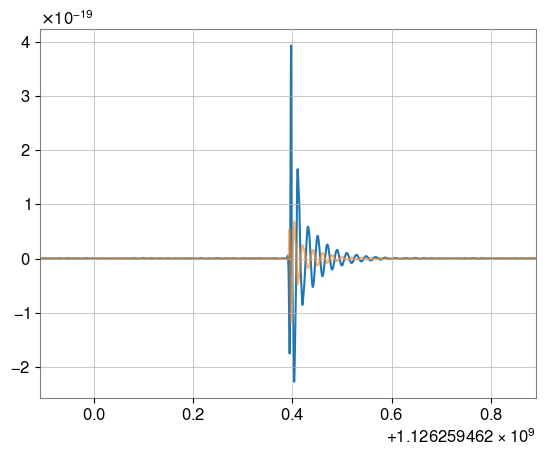

In [10]:
plt.plot(strain_H1.times, np.roll(strain_H1.value, -4096), label='H1')
plt.plot(strain_L1.times, np.roll(strain_L1.value, -4096), label='L1', alpha=0.6)
plt.xlim(trigger_time-0.5, trigger_time+0.5)
plt.show()

In [8]:
ifo_list[0].plot_time_domain_data(outdir='tests', label='td_data_GW150914')
ifo_list[1].plot_time_domain_data(outdir='tests', label='td_data_GW150914')

In [6]:
amplitude = 1
print('amplitude = ',amplitude)

priors2 = copy.copy(priors)

# test if bilby oscillatory waveform = gwmemory oscillatory waveform.
waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)


target_likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator_osc,
    time_marginalization = True,
    distance_marginalization = True,
    distance_marginalization_lookup_table = 'TD.npz',
    jitter_time=True,
    priors = priors2,
    reference_frame = args['reference_frame'],
    time_reference = args['time_reference'],
)

21:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
21:17 bilby INFO    : Loaded distance marginalisation lookup table does not match for distance_array.
/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
21:17 bilby INFO    : Building lookup table for distance marginalisation.


amplitude =  1


100%|██████████| 400/400 [00:50<00:00,  7.94it/s]


In [7]:
max_like = np.argmax(samples['log_likelihood'])
posterior = samples.iloc[max_like].to_dict()

In [8]:
reference_parameters = dict(luminosity_distance = priors2['luminosity_distance'], 
                            geocent_time = priors2['geocent_time'])
target_likelihood.parameters.update(posterior)
target_likelihood.parameters.update(reference_parameters)
print(target_likelihood.log_likelihood_ratio())
print(posterior['log_likelihood'])

327.88806594283005
328.4324942070929
